<a href="https://colab.research.google.com/github/Ramoniak/DLforNLP/blob/main/NERModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0 - Load a NER dataset (e.g. CoNLL-2003) using the provided script

In [ ]:
!pip install datasets

In [37]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Load and preprocess CoNLL-2003 dataset
conll2003 = load_dataset("conll2003")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") # breaks down text to individual units (words, subwords, chars)

from torch.nn.utils.rnn import pad_sequence
# function processes each example by tokenizing the text and aligning the NER tags with the tokenizer's output.
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i) # Mapping tokens to word indices
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)  # For padding or duplicate words, set labels to -100 (ignored in loss calculation)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(torch.tensor(label_ids))
    tokenized_inputs["input_ids"] = [torch.tensor(x) for x in tokenized_inputs["input_ids"]]
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# function prepares batches  by padding them to the same length.
def collate_fn(batch):
    input_ids = [torch.tensor(item["input_ids"]) for item in batch]
    labels = [torch.tensor(item["labels"]) for item in batch]
    input_ids = pad_sequence(input_ids, batch_first=True)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)
    return {"input_ids": input_ids, "labels": labels}


# creating data loaders for training, validation and test sets
tokenized_conll2003 = conll2003.map(tokenize_and_align_labels, batched=True, remove_columns=conll2003["train"].column_names)
train_dataloader = DataLoader(tokenized_conll2003["train"], batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(tokenized_conll2003["validation"], batch_size=32, collate_fn=collate_fn)
test_dataloader = DataLoader(tokenized_conll2003["test"], batch_size=32, collate_fn=collate_fn)

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

In [3]:
# print all labels
print(conll2003["train"].features["ner_tags"].feature.names)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


# Part 1 - custom nn.Module


*   Create a custom nn.Module class that takes Glove word embeddings as input,passes them through a linear layer, and outputs NER tags
*   Train the model using cross-entropy loss and evaluate its performance using entity-level F1 score
* Analyze the model's predictions and visualize the confusion matrix to identify common errors

Epoch 1, Train Loss: 0.8584647317139055, Validation Loss: 0.7698258623188617
Epoch 2, Train Loss: 0.6849134941850545, Validation Loss: 0.7457149507952672
Epoch 3, Train Loss: 0.6712470349934215, Validation Loss: 0.7370777065847435
Epoch 4, Train Loss: 0.6653679859801143, Validation Loss: 0.7317376025751525
Epoch 5, Train Loss: 0.6612723707338128, Validation Loss: 0.7286083338891759
Epoch 6, Train Loss: 0.6604724966312052, Validation Loss: 0.7263310078312369
Epoch 7, Train Loss: 0.6578086209324335, Validation Loss: 0.7248111469488517
Epoch 8, Train Loss: 0.6555931448664915, Validation Loss: 0.7245793453618592
Epoch 9, Train Loss: 0.6556566922431112, Validation Loss: 0.7242025125260446
Epoch 10, Train Loss: 0.6544766210206278, Validation Loss: 0.7216009994347891
Epoch 11, Train Loss: 0.6545609535144511, Validation Loss: 0.7201318840185801
Epoch 12, Train Loss: 0.652726532114937, Validation Loss: 0.7201641704521927
Epoch 13, Train Loss: 0.6529978045298461, Validation Loss: 0.7208765382860

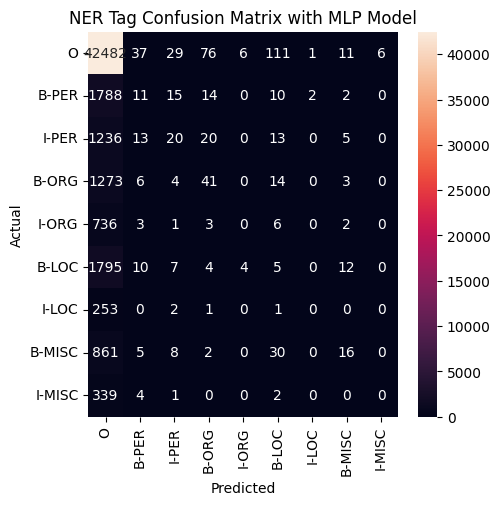

In [20]:
class ModelNER(nn.Module):
    def __init__(self, embed_dim, num_tags):
        super(ModelNER, self).__init__()
        glove = GloVe(name='6B', dim=embed_dim)
        self.embedding = nn.Embedding.from_pretrained(glove.vectors)
        self.linear = nn.Linear(embed_dim, num_tags)  # maps the embedd. dimension to the number of NER tags


    def forward(self, x):
        embedded = self.embedding(x)
        output = self.linear(embedded)
        return output

# Initialize model, loss function, and optimizer
embed_dim = 100  # GloVe embedd (e.g., 50, 100, 200, 300)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)  # number of unique NER tags from the dataset
model = ModelNER(embed_dim, num_tags)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
# Iterates over a set number of epochs, performing a forward pass, loss computation, and backpropagation for each batch.
# Stopping: 1. monitor its performance on a validation set that is not used for the actual training
#           2. if the performance on the validation set starts to degrade (overfitting), stop the process
num_epochs = 40
best_val_loss = float('inf') # keep track of the best validation loss
patience = 3 #how many epochs to continue training after no improvement
trigger_times = 0 #number of consecutive epochs without improvement
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch["input_ids"])
        loss = criterion(outputs.view(-1, num_tags), batch["labels"].view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            outputs = model(batch["input_ids"])
            loss = criterion(outputs.view(-1, num_tags), batch["labels"].view(-1))
            val_loss += loss.item()
# Check if the validation loss obtained is less than the best validation loss observed so far.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_dataloader)}, Validation Loss: {val_loss / len(val_dataloader)}")


# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
# Evaluation
model.eval()
all_preds = []
all_labels = []
for batch in val_dataloader:
    input_ids = batch["input_ids"]
    labels = batch["labels"]
    with torch.no_grad():
        outputs = model(input_ids)
    preds = torch.argmax(outputs, dim=-1)
    all_preds.extend(preds.view(-1).tolist())
    all_labels.extend(labels.view(-1).tolist())

# Removing padding for metrics calculation
clean_preds = [p for p, l in zip(all_preds, all_labels) if l != -100]
clean_labels = [l for l in all_labels if l != -100]

# Confusion Matrix and Classification Report
print(classification_report(clean_labels, clean_preds, target_names=conll2003["train"].features["ner_tags"].feature.names))
conf_mat1 = confusion_matrix(clean_labels, clean_preds)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat1, annot=True, fmt='d', xticklabels=conll2003['train'].features['ner_tags'].feature.names, yticklabels=conll2003['train'].features['ner_tags'].feature.names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('NER Tag Confusion Matrix with MLP Model')
plt.show()

Result:

*   The model is heavily biased towards predicting the 'O' class.
*   The model struggles significantly with named entity tags, particularly with I-tags.



# Part 2 - Build a multi-layer perceptron (MLP) for NER using Glove embeddings


*  Extend the previous exercise by creating an nn.Module class that defines an MLP architecture on top of Glove embeddings
*   Experiment with different hidden layer sizes and number of layers
*   Evaluate the trained model using entity-level precision, recall, and F1 scores
*   Compare the performance of the MLP model with the simple linear model from exercise


Epoch 1, Train Loss: 0.6956592355610841, Validation Loss: 0.6422161144368789
Epoch 2, Train Loss: 0.5335755162195627, Validation Loss: 0.5581775238993121
Epoch 3, Train Loss: 0.47086354268710545, Validation Loss: 0.5040703865827298
Epoch 4, Train Loss: 0.43062762797286136, Validation Loss: 0.47393545625256556
Epoch 5, Train Loss: 0.40434962239515265, Validation Loss: 0.4566936250410828
Epoch 6, Train Loss: 0.38166758889896724, Validation Loss: 0.46179740218555226
Epoch 7, Train Loss: 0.3679095486641473, Validation Loss: 0.4275348719720747
Epoch 8, Train Loss: 0.3559876740114564, Validation Loss: 0.42465462886235295
Epoch 9, Train Loss: 0.3470847953900118, Validation Loss: 0.42093732061923717
Epoch 10, Train Loss: 0.3375984733088413, Validation Loss: 0.4121463631882387
Epoch 11, Train Loss: 0.33228342883407663, Validation Loss: 0.4043983681236996
Epoch 12, Train Loss: 0.3242775628126835, Validation Loss: 0.4084499118959202
Epoch 13, Train Loss: 0.3187860528469629, Validation Loss: 0.398

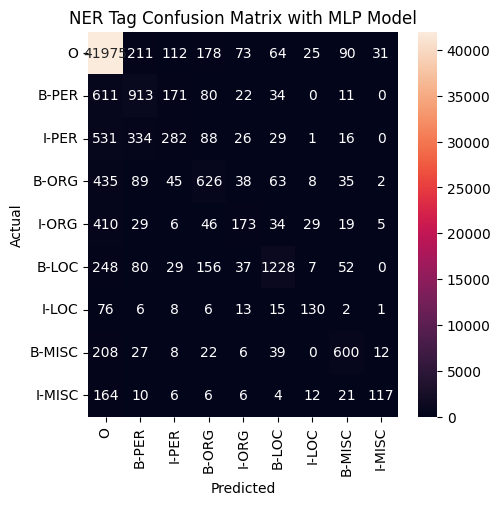

In [21]:
from torchtext.vocab import GloVe
class MLPModelNER(nn.Module):
    def __init__(self, embed_dim, num_tags, hidden_dims):
        super(MLPModelNER, self).__init__()
        glove = GloVe(name='6B', dim=embed_dim)
        self.embedding = nn.Embedding.from_pretrained(glove.vectors)
        self.linear = nn.Linear(embed_dim, num_tags)

        layers = []
        input_dim = embed_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim  # Update input dimension for the next layer

        # Final layer that outputs the class scores
        layers.append(nn.Linear(input_dim, num_tags))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        embedded = self.embedding(x)
        output = self.layers(embedded)
        return output

# Initialize model, loss function, and optimizer
embed_dim = 100  # Choose according to the GloVe vectors you load (e.g., 50, 100, 200, 300)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)
hidden_dims = [128, 64]

model = MLPModelNER(embed_dim, num_tags, hidden_dims)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#################################################
# Train the model
num_epochs = 40
best_val_loss = float('inf') # keep track of the best validation loss
patience = 3 #how many epochs to continue training after no improvement
trigger_times = 0 #number of consecutive epochs without improvement

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch["input_ids"])
        loss = criterion(outputs.view(-1, num_tags), batch["labels"].view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            outputs = model(batch["input_ids"])
            loss = criterion(outputs.view(-1, num_tags), batch["labels"].view(-1))
            val_loss += loss.item()
        # Check if the validation loss obtained is less than the best validation loss observed so far.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_dataloader)}, Validation Loss: {val_loss / len(val_dataloader)}")

############################################################################

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))
# Evaluation
model.eval()
all_preds = []
all_labels = []
for batch in val_dataloader:
    input_ids = batch["input_ids"]
    labels = batch["labels"]
    with torch.no_grad():
        outputs = model(input_ids)
    preds = torch.argmax(outputs, dim=-1)
    all_preds.extend(preds.view(-1).tolist())
    all_labels.extend(labels.view(-1).tolist())

# Removing padding for metrics calculation
clean_preds = [p for p, l in zip(all_preds, all_labels) if l != -100]
clean_labels = [l for l in all_labels if l != -100]

# Confusion Matrix and Classification Report
report2 = classification_report(clean_labels, clean_preds, target_names=conll2003["train"].features["ner_tags"].feature.names)
print(report2)
conf_mat2 = confusion_matrix(clean_labels, clean_preds)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat2, annot=True, fmt='d', xticklabels=conll2003['train'].features['ner_tags'].feature.names, yticklabels=conll2003['train'].features['ner_tags'].feature.names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('NER Tag Confusion Matrix with MLP Model')
plt.show()

In [33]:
###### some plotting

print("First Report:")
print(report1)
print("\nSecond Report:")
print(report2)

First Report:
              precision    recall  f1-score   support

           O       0.84      0.99      0.91     42759
       B-PER       0.12      0.01      0.01      1842
       I-PER       0.21      0.01      0.02      1307
       B-ORG       0.24      0.03      0.05      1341
       I-ORG       0.00      0.00      0.00       751
       B-LOC       0.03      0.00      0.00      1837
       I-LOC       0.00      0.00      0.00       257
      B-MISC       0.29      0.02      0.03       922
      I-MISC       0.00      0.00      0.00       346

    accuracy                           0.83     51362
   macro avg       0.19      0.12      0.11     51362
weighted avg       0.72      0.83      0.76     51362


Second Report:
              precision    recall  f1-score   support

           O       0.94      0.98      0.96     42759
       B-PER       0.54      0.50      0.52      1842
       I-PER       0.42      0.22      0.29      1307
       B-ORG       0.52      0.47      0.49     

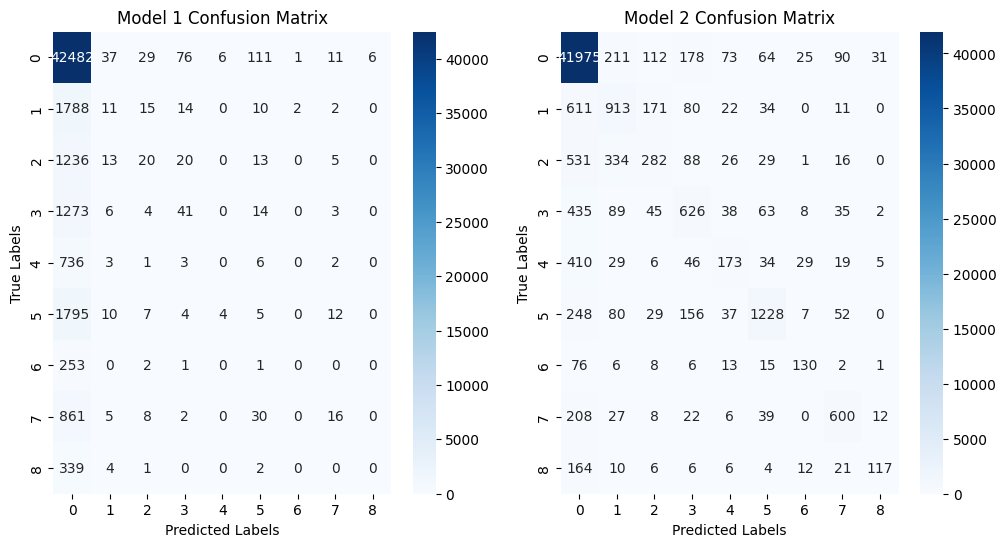

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(conf_mat1, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('Model 1 Confusion Matrix')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

sns.heatmap(conf_mat2, annot=True, fmt='d', ax=ax[1], cmap='Blues')
ax[1].set_title('Model 2 Confusion Matrix')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.show()

# Part 3 - Explore the effects of different activation functions and regularization techniques for NER


*   Modify the MLP model from exercise 2 to allow configurable activation functions (e.g. ReLU, tanh, sigmoid)
*   Train models with different activation functions.)
*  Visualize the learned entity embeddings using dimensionality reduction techniques like PCA or t-SNE (edited)



Training with ReLU activation function:
Epoch 1, Train Loss: 0.7086635749948323, Validation Loss: 0.658224918678695
Epoch 2, Train Loss: 0.538537336577044, Validation Loss: 0.5597371196045595
Epoch 3, Train Loss: 0.4764476051227378, Validation Loss: 0.5211241078727386
Epoch 4, Train Loss: 0.43697949632968336, Validation Loss: 0.4793732568037276
Epoch 5, Train Loss: 0.4071372099780819, Validation Loss: 0.45827436388707626
Epoch 6, Train Loss: 0.38544103425157367, Validation Loss: 0.44352581512694267
Epoch 7, Train Loss: 0.36975400081935395, Validation Loss: 0.42522786090187
Epoch 8, Train Loss: 0.3578484690746034, Validation Loss: 0.4208535604617175
Epoch 9, Train Loss: 0.3463810931102018, Validation Loss: 0.41979053368171054
Epoch 10, Train Loss: 0.33783592361795606, Validation Loss: 0.40493856078269436
Epoch 11, Train Loss: 0.3316567834118776, Validation Loss: 0.403534651825241
Epoch 12, Train Loss: 0.3261661358126747, Validation Loss: 0.40566060239193485
Epoch 13, Train Loss: 0.3216

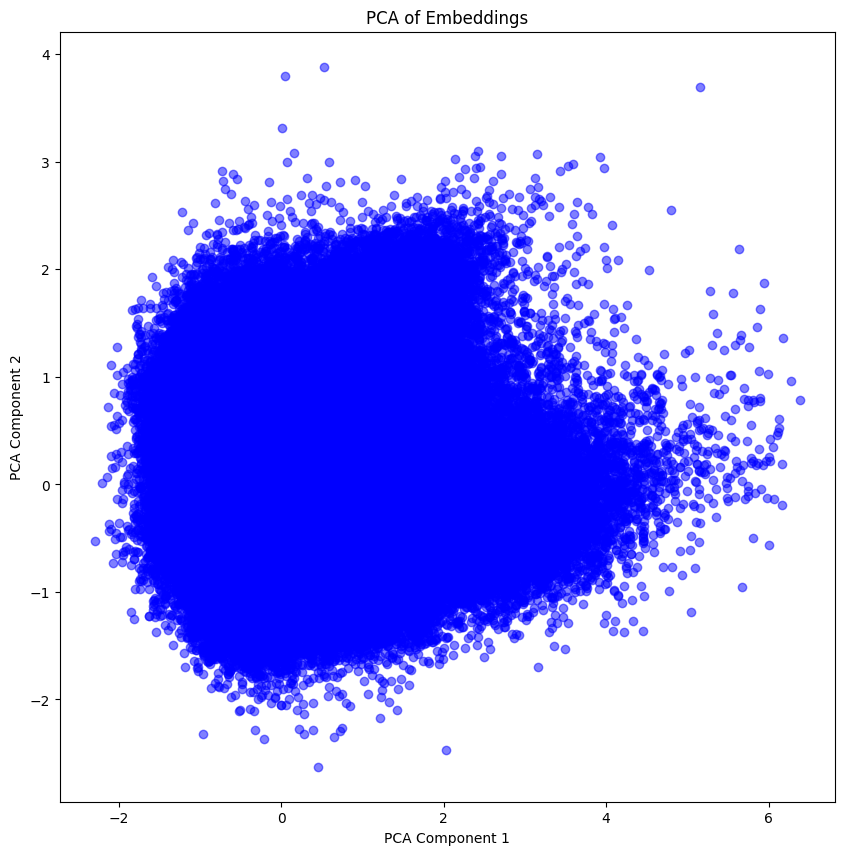

In [41]:
import torch.optim as optim
import torch.nn.functional as F
import torchtext.vocab as vocab
from datasets import load_dataset
from sklearn.decomposition import PCA

class MLP2ModelNER(nn.Module):
    def __init__(self, embed_dim, num_tags, hidden_dims, activation_func=F.relu):
        super(MLP2ModelNER, self).__init__()
        # Store the activation function as an instance variable
        self.activation_func = activation_func
        glove = vocab.GloVe(name='6B', dim=embed_dim)
        self.embedding = nn.Embedding.from_pretrained(glove.vectors)

        self.layers = nn.ModuleList()
        input_dim = embed_dim
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            input_dim = hidden_dim
        self.output_layer = nn.Linear(input_dim, num_tags)

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = self.activation_func(layer(x))
        output = self.output_layer(x)
        return output

# Testing different activation functions
activation_functions = {
    'ReLU': F.relu,
    'Tanh': torch.tanh,
    'Sigmoid': torch.sigmoid
}

for name, activation in activation_functions.items():
    print(f"\nTraining with {name} activation function:")
    model = ConfigurableMLPNER(embed_dim=100, num_tags=len(conll2003["train"].features["ner_tags"].feature.names), hidden_dims=[128, 64], activation_func=activation)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    num_epochs = 40
    best_val_loss = float('inf') # keep track of the best validation loss
    patience = 3 #how many epochs to continue training after no improvement
    trigger_times = 0 #number of consecutive epochs without improvement

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()
            outputs = model(batch["input_ids"])
            loss = criterion(outputs.view(-1, num_tags), batch["labels"].view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in val_dataloader:
                outputs = model(batch["input_ids"])
                loss = criterion(outputs.view(-1, num_tags), batch["labels"].view(-1))
                val_loss += loss.item()
            # Check if the validation loss obtained is less than the best validation loss observed so far.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_dataloader)}, Validation Loss: {val_loss / len(val_dataloader)}")
# Visualizing the embeddings using PCA
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Evaluate mode to disable dropout, etc.
embeddings = model.embedding.weight.detach().cpu().numpy()
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)


all_preds = []
all_labels = []
for batch in val_dataloader:
    input_ids = batch["input_ids"]
    labels = batch["labels"]
    with torch.no_grad():
        outputs = model(input_ids)
    preds = torch.argmax(outputs, dim=-1)
    all_preds.extend(preds.view(-1).tolist())
    all_labels.extend(labels.view(-1).tolist())

clean_preds = [p for p, l in zip(all_preds, all_labels) if l != -100]
clean_labels = [l for l in all_labels if l != -100]

print(classification_report(clean_labels, clean_preds, target_names=conll2003["train"].features["ner_tags"].feature.names))

plt.figure(figsize=(10, 10))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c='blue', alpha=0.5)
plt.title('PCA of Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [45]:
report3 = classification_report(clean_labels, clean_preds, target_names=conll2003["train"].features["ner_tags"].feature.names)

In [46]:
print("First Report:")
print(report1)
print("\nSecond Report:")
print(report2)
print("\nThird Report:")
print(report3)

First Report:
              precision    recall  f1-score   support

           O       0.84      0.99      0.91     42759
       B-PER       0.12      0.01      0.01      1842
       I-PER       0.21      0.01      0.02      1307
       B-ORG       0.24      0.03      0.05      1341
       I-ORG       0.00      0.00      0.00       751
       B-LOC       0.03      0.00      0.00      1837
       I-LOC       0.00      0.00      0.00       257
      B-MISC       0.29      0.02      0.03       922
      I-MISC       0.00      0.00      0.00       346

    accuracy                           0.83     51362
   macro avg       0.19      0.12      0.11     51362
weighted avg       0.72      0.83      0.76     51362


Second Report:
              precision    recall  f1-score   support

           O       0.94      0.98      0.96     42759
       B-PER       0.54      0.50      0.52      1842
       I-PER       0.42      0.22      0.29      1307
       B-ORG       0.52      0.47      0.49     